In [1]:
import torch
import torch.nn as nn
# from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.efficientnet import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.nn.functional as F

from PIL import Image
import os

In [2]:
weights = EfficientNet_V2_S_Weights.DEFAULT
transforms = weights.transforms()
eff_net = efficientnet_v2_s(weights=weights)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from IPython.display import clear_output


In [5]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(DEVICE)

clear_output()

In [6]:
!wget -O data.zip https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -O text.zip https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip data.zip -d data/
!unzip text.zip -d data/



# Clear output
clear_output()

In [7]:
!rm -rf /content/Flicker8k_Dataset

In [6]:
import pandas as pd

df = pd.read_csv('data/Flickr8k.token.txt', sep='#\d\t', header=None, ).iloc[:20000]
df.shape

/tmp/ipykernel_21494/2839622708.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data/Flickr8k.token.txt', sep='#\d\t', header=None, ).iloc[:20000]


(20000, 2)

In [7]:
import os
df.head()

,0,1
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

In [9]:
class FlickrDataset(Dataset):
  def __init__(self, df, transform=transforms, image_folder=None):
    self.df = df
    self.transform = transform
    self.folder = image_folder

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx, 0]
    if img_name == '2258277193_586949ec62.jpg.1':
      idx += 1
      img_name = self.df.iloc[idx, 0]
    captions = self.df.iloc[idx, 1]
    tokens = self.transform_text(captions)

    input_ids = tokens.input_ids.squeeze()
    attention_mask = tokens.attention_mask.squeeze()

    img_path = os.path.join(self.folder, img_name)

    img = Image.open(img_path)
    img = self.transform(img)
    return img, (input_ids, attention_mask)

  def transform_text(self, text):
    return tokenizer(text, return_tensors="pt", truncation=True, padding="max_length")



train_dataset = FlickrDataset(train_df, transforms, 'data/Flicker8k_Dataset')
val_dataset = FlickrDataset(val_df, transforms, 'data/Flicker8k_Dataset')
test_dataset = FlickrDataset(test_df, transforms, 'data/Flicker8k_Dataset')

len(train_dataset), len(val_dataset), len(test_dataset)

(16000, 2000, 2000)

In [10]:
# generating dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [11]:
class VisionEncoder(nn.Module):
  def __init__(self, hidden_dim, output_dim, freeze_backbone=False):
    super(VisionEncoder, self).__init__()
    self.model = eff_net
    #freeze model weights
    if freeze_backbone:
      for param in self.model.parameters():
        param.requires_grad = False

    self.model.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=output_dim)
    )

  def forward(self, x):
    return self.model(x)

In [12]:
class TextEncoder(nn.Module):
  def __init__(self, hidden_dim, output_dim, freeze_backbone=False):
    super(TextEncoder, self).__init__()
    self.model = text_model
    # freeze model weights
    if freeze_backbone:
      for param in self.model.parameters():
        param.requires_grad = False
    self.fc = nn.Sequential(
        nn.Linear(in_features=768, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=output_dim)
    )

  def forward(self, x):
    input_ids, attention_mask = x
    x = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    return self.fc(x)

In [13]:
class MiniCLIP(nn.Module):
  def __init__(self, vision_encoder, text_encoder):
    super(MiniCLIP, self).__init__()
    self.vision_encoder = vision_encoder
    self.text_encoder = text_encoder

    self.temperature = nn.Parameter(torch.tensor(1.0))

  def get_similarity(self, image_features, text_features):
    return (image_features @ text_features.T) * torch.exp(self.temperature)

  def get_image_features(self, image):
    return self.vision_encoder(image)

  def get_text_features(self, text):
    return self.text_encoder(text)

  def forward(self, image, text):
    image_features = F.normalize(self.get_image_features(image))
    text_features = F.normalize(self.get_text_features(text))
    similarities = self.get_similarity(image_features, text_features)
    return similarities

# Training Setup

In [14]:
class SymmetricLoss(nn.Module):
  def __init__(self):
    super(SymmetricLoss, self).__init__()
    self.criterion_image = nn.CrossEntropyLoss()
    self.criterion_text = nn.CrossEntropyLoss()

  def forward(self, logits):
    labels = torch.arange(logits.size(0)).to(DEVICE)
    loss_i = self.criterion_image(logits, labels)
    loss_t = self.criterion_text(logits.T, labels)
    sym_loss = (loss_i + loss_t) / 2
    return sym_loss

In [15]:
from torch.optim import AdamW
from torch.optim import lr_scheduler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_HIDDEN_DIM = 512
IMAGE_OUTPUT_DIM = 256
TEXT_HIDDEN_DIM = 512
TEXT_OUTPUT_DIM = 256
EPOCHS = 10
LEARNNING_RATE = 1e-3

vision_encoder = VisionEncoder(IMAGE_HIDDEN_DIM, IMAGE_OUTPUT_DIM).to(DEVICE)
text_encoder = TextEncoder(TEXT_HIDDEN_DIM, TEXT_OUTPUT_DIM).to(DEVICE)
miniclip = MiniCLIP(vision_encoder, text_encoder).to(DEVICE)

optimizer = AdamW(miniclip.parameters(), lr=LEARNNING_RATE)
scheduler = lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=LEARNNING_RATE, epochs=EPOCHS, steps_per_epoch=len(train_loader))
criterion = SymmetricLoss()

## Training loop

In [16]:
from tqdm.notebook import tqdm
import gc

In [17]:
from tqdm import tqdm

def train_step(model, optimizer, criterion, dataloader):
  model.train()
  total_loss = 0

  # Create the tqdm progress bar with a dynamic description
  progress_bar = tqdm(dataloader, total=len(dataloader), desc="Avg Train Loss: 0.000")

  for i, (image, text) in enumerate(progress_bar):
    try:
      # Put everything on the same device
      image = image.to(DEVICE)
      input_ids, attention_mask = text[0].to(DEVICE), text[1].to(DEVICE)

      # Optimizer zero grad
      optimizer.zero_grad()

      # Get logits
      logits = model(image, (input_ids, attention_mask))

      # Calculate loss
      loss = criterion(logits)
      total_loss += loss.item()

      # Backward pass and optimizer step
      loss.backward()
      optimizer.step()

      # Update the tqdm description with the running average loss
      avg_loss = total_loss / (i + 1)
      progress_bar.set_description(f"Avg Train Loss: {avg_loss:.4f}")
    except Exception as e:
      print(e)
      continue
    
    torch.cuda.empty_cache()
    gc.collect()

  # Return the average loss for the epoch
  return total_loss / len(dataloader)


In [18]:
def val_step(model, criterion, dataloader):
  model.eval()
  with torch.inference_mode():
    total_loss = 0

    progress_bar = tqdm(dataloader, total=len(dataloader), desc="Avg Val Loss: 0.000")

    for i, (image, text) in enumerate(progress_bar):
      # Put everything on the same device
      try:
        image = image.to(DEVICE)
        input_ids, attention_mask = text[0].to(DEVICE), text[1].to(DEVICE)

        # Get logits
        logits = model(image, (input_ids, attention_mask))

        # Calculate loss
        loss = criterion(logits)
        total_loss += loss.item()

        # Update the tqdm description with the running average loss
        avg_loss = total_loss / (i + 1)
        progress_bar.set_description(f"Avg Val Loss: {avg_loss:.4f}")

      except Exception as e:
        print(e)

  # Return the average loss for the epoch
  return total_loss / len(dataloader)


In [19]:
def train(model, optimizer, criterion, train_loader, val_loader, epochs=10):
  # setting evaluations
  history = {
        "train_loss": [],
        "val_loss": [],
    }
  for epoch in range(epochs):
    
    best_val_loss = float("inf")
    train_loss = train_step(model, optimizer, criterion, train_loader)
    val_loss = val_step(model, criterion, val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), "models/best_modelv2.pt")
      torch.save(vision_encoder.state_dict(), "models/vision_state_dictv2.pt")
      torch.save(text_encoder.state_dict(), "models/text_state_dictv2.pt")
      
  
  return history

In [20]:
history = train(model=miniclip, optimizer=optimizer, criterion=criterion, train_loader=train_loader, val_loader=val_loader, epochs=10)

Avg Val Loss: 0.4556: 100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


Epoch 1/10, Train Loss: 0.5767, Val Loss: 0.4556


Avg Val Loss: 0.3514: 100%|██████████| 500/500 [00:35<00:00, 14.19it/s]


Epoch 2/10, Train Loss: 0.3529, Val Loss: 0.3514


Avg Val Loss: 0.2970: 100%|██████████| 500/500 [00:39<00:00, 12.74it/s]


Epoch 3/10, Train Loss: 0.2636, Val Loss: 0.2970


Avg Val Loss: 0.2476: 100%|██████████| 500/500 [00:37<00:00, 13.37it/s]


Epoch 4/10, Train Loss: 0.2148, Val Loss: 0.2476


Avg Val Loss: 0.2333: 100%|██████████| 500/500 [00:39<00:00, 12.79it/s]


Epoch 5/10, Train Loss: 0.1717, Val Loss: 0.2333


Avg Val Loss: 0.1957: 100%|██████████| 500/500 [00:38<00:00, 13.02it/s]


Epoch 6/10, Train Loss: 0.1583, Val Loss: 0.1957


Avg Val Loss: 0.1958: 100%|██████████| 500/500 [00:38<00:00, 12.83it/s]


Epoch 7/10, Train Loss: 0.1318, Val Loss: 0.1958


Avg Val Loss: 0.2087: 100%|██████████| 500/500 [00:38<00:00, 13.07it/s]


Epoch 8/10, Train Loss: 0.1184, Val Loss: 0.2087


Avg Val Loss: 0.1727: 100%|██████████| 500/500 [00:35<00:00, 14.10it/s]


Epoch 9/10, Train Loss: 0.1090, Val Loss: 0.1727


Avg Val Loss: 0.1752: 100%|██████████| 500/500 [00:35<00:00, 14.17it/s]


Epoch 10/10, Train Loss: 0.1012, Val Loss: 0.1752


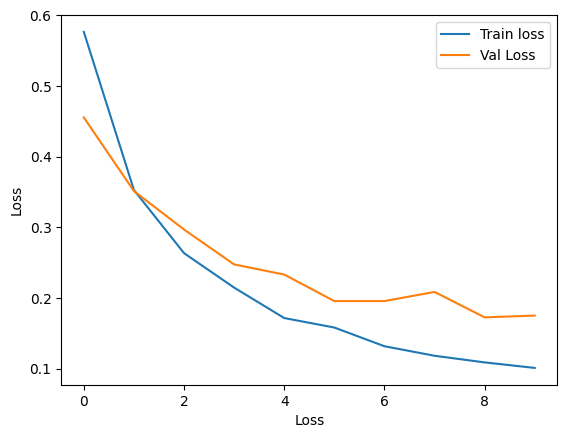

In [22]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label="Train loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history['val_loss'], label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.xlabel("Loss")
plt.show()

# Inference

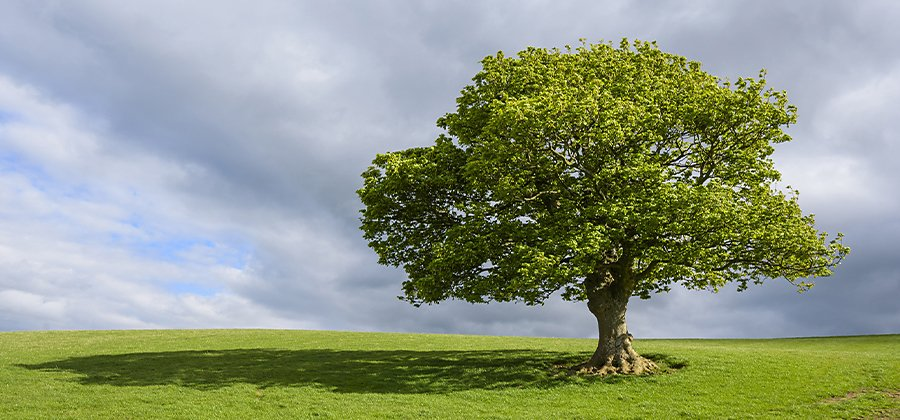

In [24]:
import requests
from PIL import Image
url = 'https://cc-prod.scene7.com/is/image/CCProdAuthor/draw-trees_P1_900x420?$pjpeg$&jpegSize=200&wid=900'
img = Image.open(requests.get(url, stream=True).raw)
img

In [25]:
transformed_img = transforms(img)

In [42]:
sample_texts = ["a car on a road", "a man eating mango", "a tree and grass", "a dog running"]
tokens = tokenizer(sample_texts, return_tensors="pt", truncation=True, padding="max_length")

In [63]:
preds = F.softmax(miniclip(transformed_img.unsqueeze(0).to(DEVICE), (tokens.input_ids.to(DEVICE), tokens.attention_mask.to(DEVICE))), dim=-1)
print((preds*100).tolist())
sample_texts[preds.argmax(dim=-1)]

[[0.05565634369850159, 0.226617693901062, 95.71355438232422, 4.0041632652282715]]


'a tree and grass'

In [41]:
from typing import List
def find_similarity(model, image, texts: List[str]):
  model.eval()
  with torch.inference_mode():
    transformed_img = transforms(image)
    tokens = tokenizer(texts, return_tensors="pt", truncation=True, padding="max_length")
    logits = miniclip(transformed_img.unsqueeze(0).to(DEVICE), (tokens.input_ids.to(DEVICE), tokens.attention_mask.to(DEVICE)))
    pred_probs = F.softmax(logits, dim=-1)
    pred_idx = pred_probs.argmax(dim=-1)

    return {"prediction_probabilities": pred_probs.squeeze().detach().cpu().tolist(),
            "predicted_label": pred_idx}

In [55]:
find_similarity(miniclip, img, sample_texts)

{'prediction_probabilities': [0.0005565634346567094,
  0.002266176976263523,
  0.9571355581283569,
  0.04004163295030594],
 'predicted_label': tensor([2], device='cuda:0')}